# QC of the PDBP genotyping data

In this notebook, we will run certain scripts written in R.

This notebook suplements "Py - data QC" to run this certain R scripts

## Loading / installling libs

In [2]:
# Utility routine for installing packages
install_if_missing <- function(packages) {
    if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
        install.packages(setdiff(packages, rownames(installed.packages())))
    }
}

In [3]:
install_if_missing(c('tidyverse', 'reticulate'))

In [4]:
library(tidyverse)  # Data wrangling packages.
library(reticulate) # R Interface to Python

# Expect these to be installed by default
library(Ronaldo)    # Leonardo R package.
library(bigrquery)  # BigQuery R client.
library(ggplot2)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Utils

In [5]:
# Utility routine for printing a shell command before executing it
shell_do <- function(command) {
    print(paste('Executing: ', command))
    system(command, intern = TRUE)
}

# Utility routines for reading files from Google Cloud Storage
gcs_read_file <- function(path) {
    pipe(str_glue('gsutil -u {BILLING_PROJECT_ID} cat {path}'))
}
gcs_read_csv <- function(path, sep=',') {
    readr::read_csv(gcs_read_file(path))
}

# Utility routine for display a message and a link
display_html_link <- function(description, link_text, url) {
    html = str_glue('
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    ')

    IRdisplay::display_html(html)
}

# Utility routine for displaying a message and link to Cloud Console
link_to_cloud_console_gcs <- function(description, link_text, gcs_path) {
    url_path <- file.path('https://console.cloud.google.com/storage/browser',
                          str_replace(gcs_path, "gs://",""))
    url_query <- str_glue('userProject={URLencode(BILLING_PROJECT_ID)}')

    url = str_glue('{url_path}?{url_query}')

    display_html_link(description, link_text, url)
}


## Heterozygosity checking

In [6]:
shell_do("head /home/jupyter/notebooks/working_dir/amppd_PDBPsamples.geno_005.maf_0.01.king_0.1.sexUpdated.mishet.smiss")
shell_do("head /home/jupyter/notebooks/working_dir/amppd_PDBPsamples.geno_005.maf_0.01.king_0.1.sexUpdated.mishet.het")


[1] "Executing:  head /home/jupyter/notebooks/working_dir/amppd_PDBPsamples.geno_005.maf_0.01.king_0.1.sexUpdated.mishet.smiss"


[1] "#FID\tIID\tMISSING_CT\tOBS_CT\tF_MISS"                    
 [2] "PD-PDAA503EF5\tPD-PDAA503EF5\t17097\t11886519\t0.00143835"
 [3] "PD-PDAB074CYQ\tPD-PDAB074CYQ\t18202\t12023465\t0.00151387"
 [4] "PD-PDAB549YWB\tPD-PDAB549YWB\t20883\t12023465\t0.00173685"
 [5] "PD-PDAB729HWD\tPD-PDAB729HWD\t12396\t12023465\t0.00103098"
 [6] "PD-PDAB762PA3\tPD-PDAB762PA3\t9637\t11886519\t0.00081075" 
 [7] "PD-PDAC268KWV\tPD-PDAC268KWV\t12534\t11886519\t0.00105447"
 [8] "PD-PDAD926WRZ\tPD-PDAD926WRZ\t13789\t12023465\t0.00114684"
 [9] "PD-PDAE854KGZ\tPD-PDAE854KGZ\t17104\t12023465\t0.00142255"
[10] "PD-PDAF772WHX\tPD-PDAF772WHX\t19155\t12023465\t0.00159313"

[1] "Executing:  head /home/jupyter/notebooks/working_dir/amppd_PDBPsamples.geno_005.maf_0.01.king_0.1.sexUpdated.mishet.het"


[1] "#FID\tIID\tO(HOM)\tE(HOM)\tOBS_CT\tF"                                     
 [2] "PD-PDAA503EF5\tPD-PDAA503EF5\t8764846\t8.69952e+06\t11481826\t0.0234773"  
 [3] "PD-PDAB074CYQ\tPD-PDAB074CYQ\t8783291\t8.7011e+06\t11484359\t0.0295291"   
 [4] "PD-PDAB549YWB\tPD-PDAB549YWB\t8790830\t8.69982e+06\t11482450\t0.0327065"  
 [5] "PD-PDAB729HWD\tPD-PDAB729HWD\t8785489\t8.70509e+06\t11489414\t0.0288748"  
 [6] "PD-PDAB762PA3\tPD-PDAB762PA3\t8765613\t8.70494e+06\t11489185\t0.0217927"  
 [7] "PD-PDAC268KWV\tPD-PDAC268KWV\t8769206\t8.70262e+06\t11486357\t0.0239188"  
 [8] "PD-PDAD926WRZ\tPD-PDAD926WRZ\t8685081\t8.70433e+06\t11488349\t-0.00691299"
 [9] "PD-PDAE854KGZ\tPD-PDAE854KGZ\t8773100\t8.70212e+06\t11485544\t0.0254995"  
[10] "PD-PDAF772WHX\tPD-PDAF772WHX\t8799708\t8.70124e+06\t11484522\t0.0353787"

In [7]:
smiss_data = read_tsv(file = "/home/jupyter/notebooks/working_dir/amppd_PDBPsamples.geno_005.maf_0.01.king_0.1.sexUpdated.mishet.smiss")
het_data = read_tsv(file = "/home/jupyter/notebooks/working_dir/amppd_PDBPsamples.geno_005.maf_0.01.king_0.1.sexUpdated.mishet.het")

head(smiss_data)
head(het_data)

Rows: 843 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): #FID, IID
dbl (3): MISSING_CT, OBS_CT, F_MISS


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 843 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): #FID, IID
dbl (4): O(HOM), E(HOM), OBS_CT, F


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



#FID,IID,MISSING_CT,OBS_CT,F_MISS
<chr>,<chr>,<dbl>,<dbl>,<dbl>
PD-PDAA503EF5,PD-PDAA503EF5,17097,11886519,0.00143835
PD-PDAB074CYQ,PD-PDAB074CYQ,18202,12023465,0.00151387
PD-PDAB549YWB,PD-PDAB549YWB,20883,12023465,0.00173685
PD-PDAB729HWD,PD-PDAB729HWD,12396,12023465,0.00103098
PD-PDAB762PA3,PD-PDAB762PA3,9637,11886519,0.00081075
PD-PDAC268KWV,PD-PDAC268KWV,12534,11886519,0.00105447


#FID,IID,O(HOM),E(HOM),OBS_CT,F
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
PD-PDAA503EF5,PD-PDAA503EF5,8764846,8699520,11481826,0.0234773
PD-PDAB074CYQ,PD-PDAB074CYQ,8783291,8701100,11484359,0.0295291
PD-PDAB549YWB,PD-PDAB549YWB,8790830,8699820,11482450,0.0327065
PD-PDAB729HWD,PD-PDAB729HWD,8785489,8705090,11489414,0.0288748
PD-PDAB762PA3,PD-PDAB762PA3,8765613,8704940,11489185,0.0217927
PD-PDAC268KWV,PD-PDAC268KWV,8769206,8702620,11486357,0.0239188


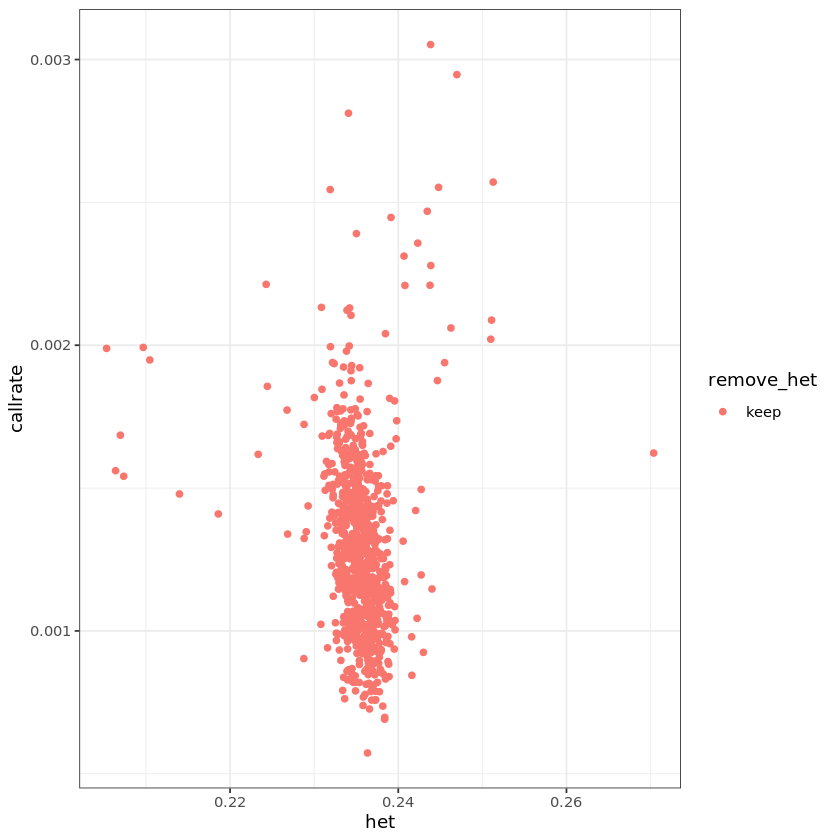

In [11]:
#Read in sample heterozygosity table
sample_het <- het_data
#Read in sample call rate table
sample_callrate <- smiss_data

#Calculate proportion of heterozygosity
sample_het <- sample_het %>%
  mutate(het = (OBS_CT - `O(HOM)`)/OBS_CT)

#Calculate mean and SD of heterozygosity
summary <- sample_het %>%
  summarise(mean_het = mean(het),
            sd_het = sd(het))

mean_het <- summary[1,1]
sd_het <- summary[1,2]

#Write list of samples who are > 2 SDs from mean of heterozygosity
sample_het <- sample_het %>%
  mutate(remove_het = ifelse(het > 2*sd_het + mean_het, "remove",
                             ifelse(het < mean_het - 2*sd_het, "remove", "keep")))

#Merge with callrate table
sample_stats <- sample_het %>%
  left_join(sample_callrate, by = c("#FID", "IID"))

sample_stats <- sample_stats %>%
  mutate(callrate = F_MISS)

#Plot scatterplot
ggplot(data = sample_stats, mapping = aes(x = het, y = callrate, color = remove_het)) +
  geom_point() +
  theme_bw() 

#Write list of samples to remove - if heterozygosity outliers or if callrate is <98%
samples_to_remove <- sample_stats %>%
  filter(remove_het == "remove" | callrate > 0.015) %>%
  select("#FID", IID)


In [12]:
print(samples_to_remove)

# A tibble: 0 × 2
# … with 2 variables: #FID <chr>, IID <chr>


## Ancestry checking

In [14]:
shell_do("head /home/jupyter/notebooks/working_dir/PCA.eigenvec")
#shell_do("head /home/jupyter/notebooks/working_dir/amppd_PDBPsamples.geno_005.maf_0.01.king_0.1.sexUpdated.mishet.het")


[1] "Executing:  head /home/jupyter/notebooks/working_dir/PCA.eigenvec"


[1] "1328 NA06984 -0.0162921 0.0125582 -0.000989139 0.00861451 0.00235827 -0.00596811 0.01481 -0.00852821 -0.00380554 3.04191e-05"   
 [2] "1328 NA06989 -0.0166102 0.0120894 -0.00709327 0.0049359 0.00150665 -0.0163311 -0.0032385 -0.0143991 -0.00170513 -0.0111132"     
 [3] "1330 NA12335 -0.0169009 0.0120177 -0.00220323 0.00675424 0.000632861 -0.0130202 -0.00970769 -0.00456799 -0.00481704 -0.00609671"
 [4] "1330 NA12336 -0.0170209 0.0108739 0.000768671 0.0111145 -0.00217156 -0.00751972 0.00911231 -0.0071722 0.0110957 -0.0212121"     
 [5] "1330 NA12340 -0.0164617 0.0126481 -0.00338646 0.0109329 -0.000918 -0.00352974 -0.000738066 0.000645392 -0.0067121 -0.0038024"   
 [6] "1330 NA12341 -0.01674 0.012921 -0.00313844 0.00812707 0.000733062 -0.0138579 -0.00126938 -0.00427579 0.0017551 0.00203691"      
 [7] "1330 NA12342 -0.0172906 0.0113904 0.000719932 0.00698668 0.00356418 -0.018606 0.00570517 -0.0149877 0.00992607 -0.00216107"     
 [8] "1330 NA12343 -0.0164176 0.0115195 -0.00179117 0.00726755 -0.000975055 0.0108072 0.00376958 0.00929541 0.0143964 -0.0240515"     
 [9] "1334 NA10846 -0.0171153 0.0109003 0.00434901 0.00581628 0.00841862 0.00511303 -0.00606306 0.0142063 -0.0034187 -0.00517704"     
[10] "1334 NA10847 -0.0177526 0.0115486 -0.00325456 0.00720457 0.000102043 -0.00977176 0.0102573 -0.00406401 0.0011177 -0.0120044"

In [15]:
geneticPCA_hapmap.eigenvec =as_tibble(read.table(file = "/home/jupyter/notebooks/working_dir/PCA.eigenvec", sep =""))
HapMap_pops = as_tibble(read.table(file = "/home/jupyter/notebooks/working_dir/populations_hapmap.txt", 
                                   sep ="",header = TRUE))
#Change column names
geneticPCA_hapmap.eigenvec <- geneticPCA_hapmap.eigenvec %>%
  dplyr::rename(FID = V1,
                IID = V2,
                PC1 = V3,
                PC2 = V4,
                PC3 = V5,
                PC4 = V6,
                PC5 = V7,
                PC6 = V8,
                PC7 = V9,
                PC8 = V10,
                PC9 = V11,
                PC10 = V12)

head(geneticPCA_hapmap.eigenvec)
head(HapMap_pops)
cohort = "PDBP"

FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1328,NA06984,-0.0162921,0.0125582,-0.000989139,0.00861451,0.002358270,-0.00596811,0.014810000,-0.008528210,-0.00380554,3.04191e-05
1328,NA06989,-0.0166102,0.0120894,-0.007093270,0.00493590,0.001506650,-0.01633110,-0.003238500,-0.014399100,-0.00170513,-1.11132e-02
1330,NA12335,-0.0169009,0.0120177,-0.002203230,0.00675424,0.000632861,-0.01302020,-0.009707690,-0.004567990,-0.00481704,-6.09671e-03
1330,NA12336,-0.0170209,0.0108739,0.000768671,0.01111450,-0.002171560,-0.00751972,0.009112310,-0.007172200,0.01109570,-2.12121e-02
1330,NA12340,-0.0164617,0.0126481,-0.003386460,0.01093290,-0.000918000,-0.00352974,-0.000738066,0.000645392,-0.00671210,-3.80240e-03
1330,NA12341,-0.0167400,0.0129210,-0.003138440,0.00812707,0.000733062,-0.01385790,-0.001269380,-0.004275790,0.00175510,2.03691e-03


FID,IID,dad,mom,sex,pheno,population
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
2357,NA19625,0,0,2,0,ASW
2367,NA19702,NA19700,NA19701,1,0,ASW
2367,NA19700,0,0,1,0,ASW
2367,NA19701,0,0,2,0,ASW
2368,NA19705,NA19703,NA19704,1,0,ASW
2368,NA19703,0,0,1,0,ASW


Joining, by = c("FID", "IID")



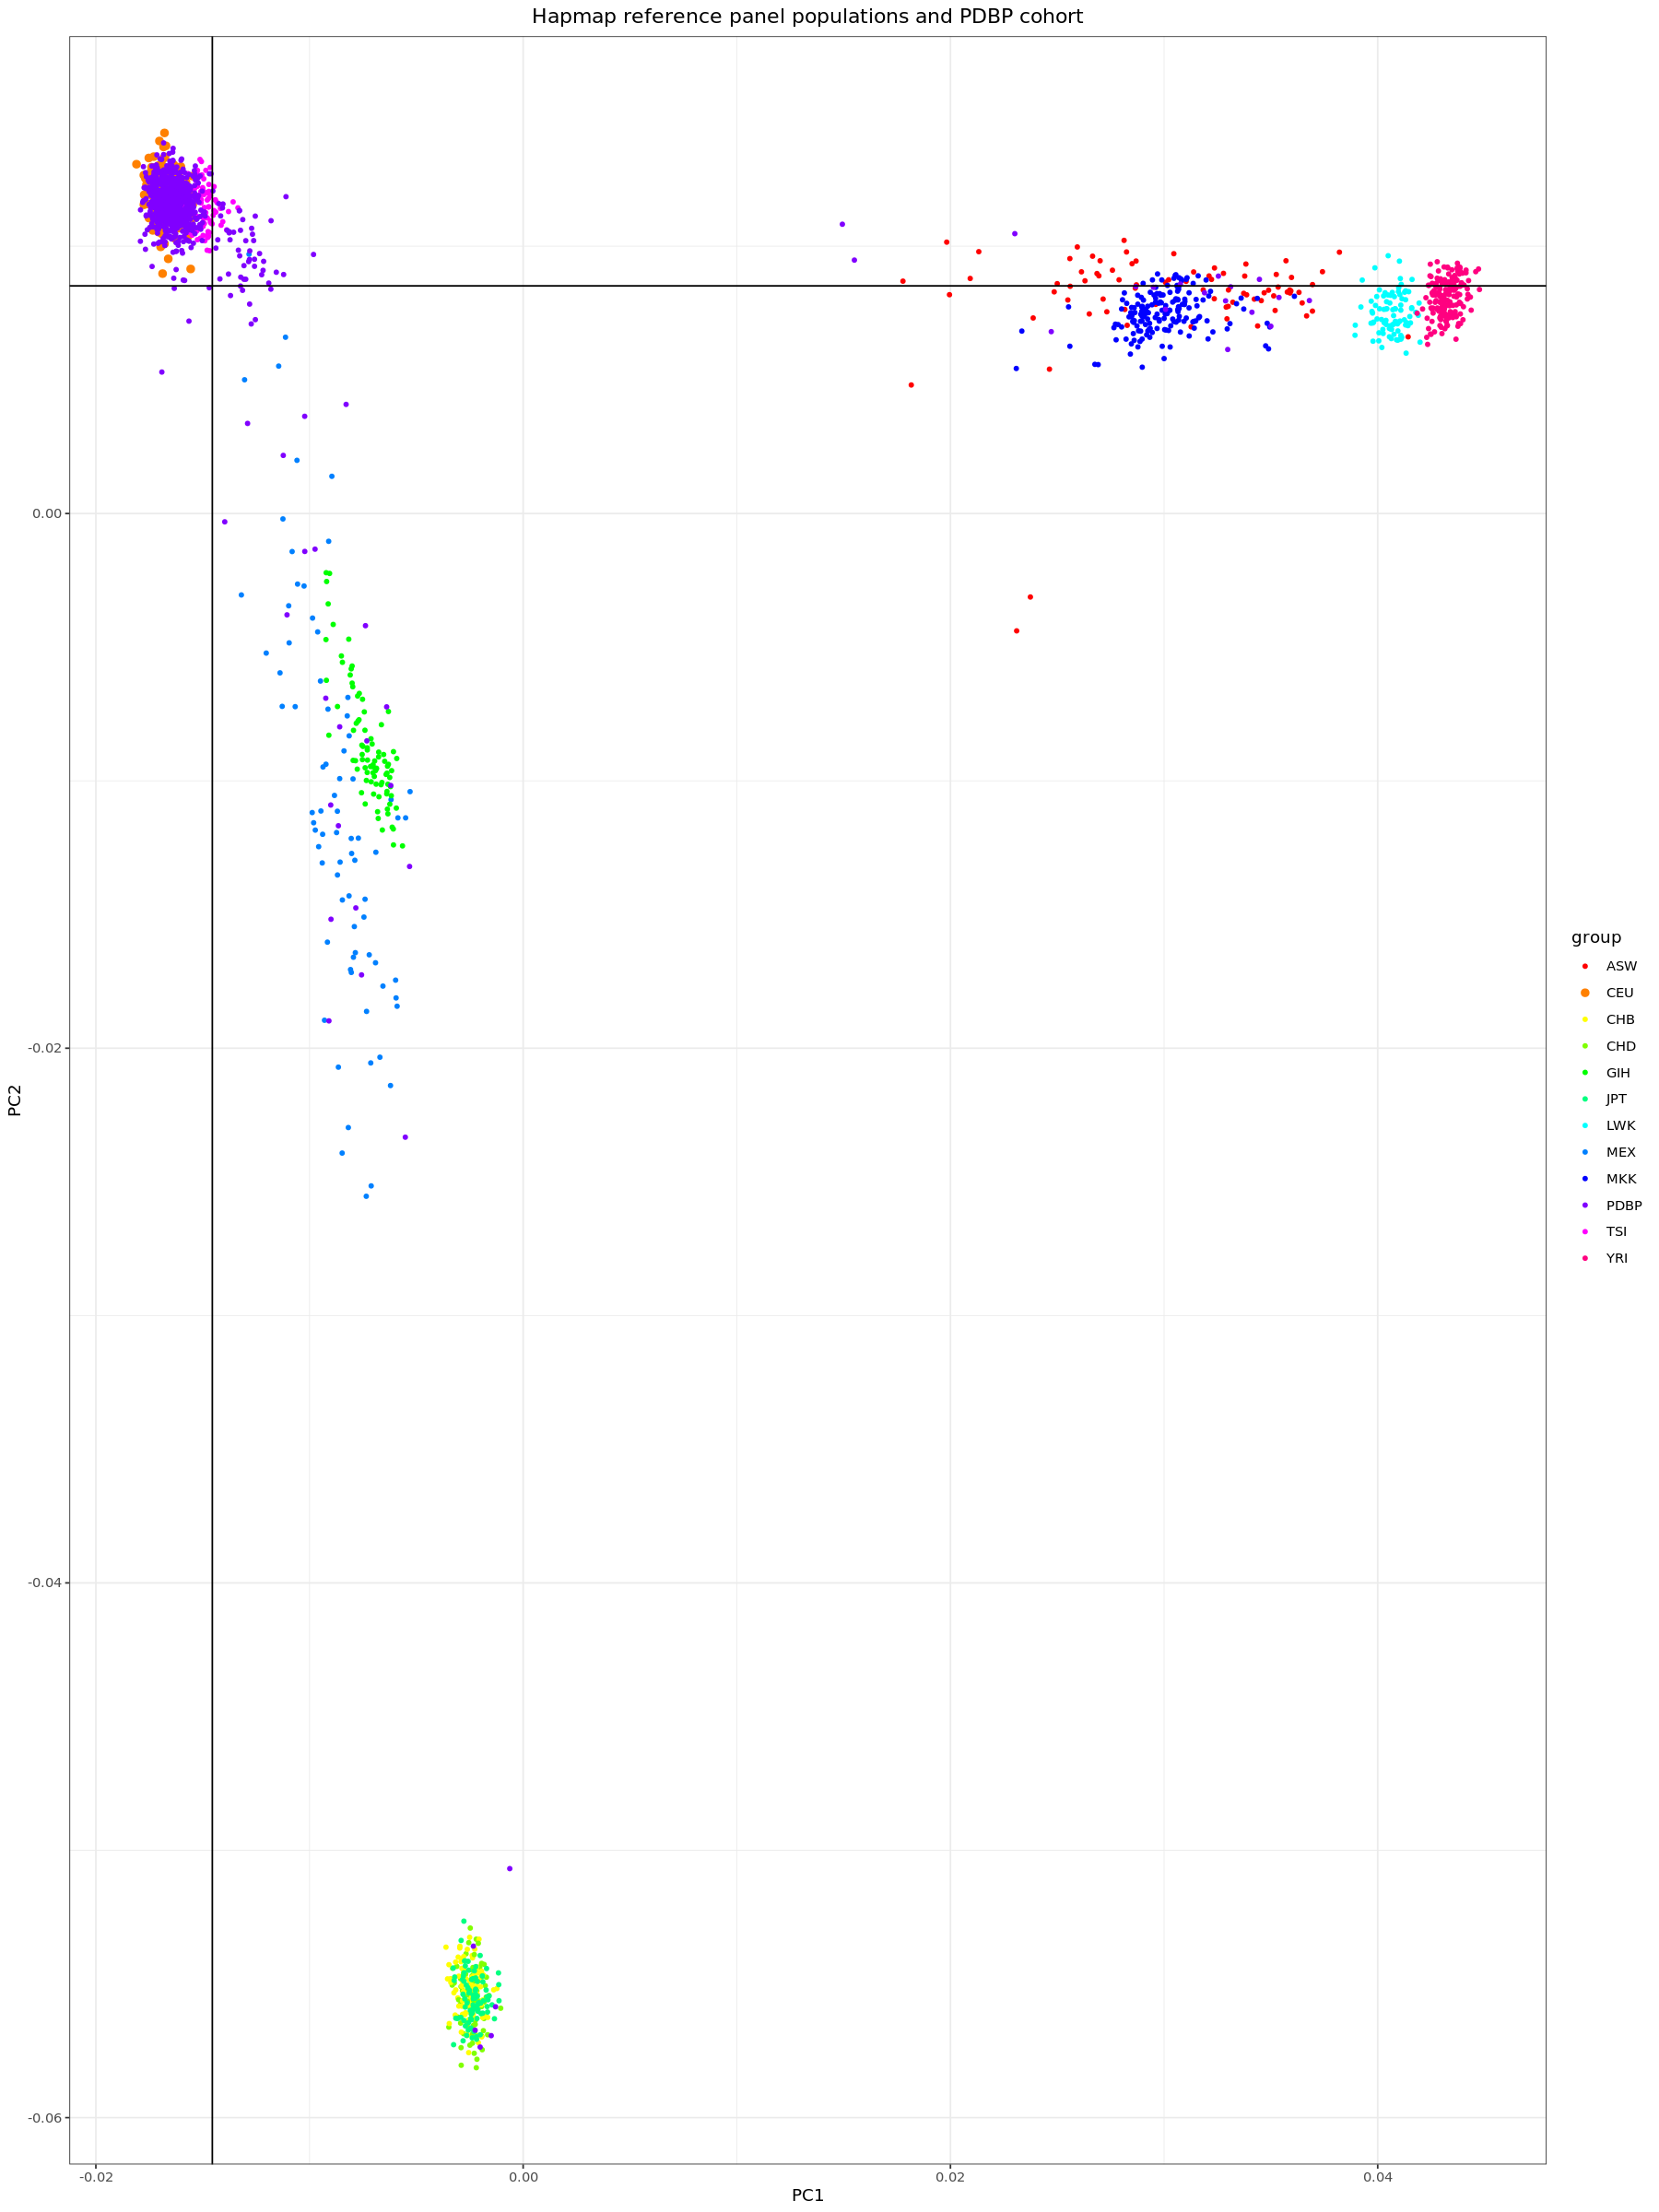

In [16]:
#---Merge PCA data with HapMap population data---####
geneticPCA_hapmap.eigenvec$FID <- as.factor(geneticPCA_hapmap.eigenvec$FID)
geneticPCA_hapmap.eigenvec <- geneticPCA_hapmap.eigenvec %>%
  left_join(HapMap_pops)

# If the population is missing, these should be the samples we are studying
geneticPCA_hapmap.eigenvec <- geneticPCA_hapmap.eigenvec %>%
  dplyr::mutate(group = ifelse(!is.na(population), population, cohort))

# geneticPCA_hapmap.eigenvec %>%
#     group_by(group) %>%
#     dplyr::summarise(count = n())

geneticPCA.eigenvec.CEU <- geneticPCA_hapmap.eigenvec %>%
   filter(group == "CEU")

options(repr.plot.width=15, repr.plot.height=20)
#---Plot first two Principal Components with HapMap samples---####
ggplot(data = geneticPCA_hapmap.eigenvec, aes(x = PC1, y = PC2, colour = group, size = group)) +
  geom_point() +
  geom_vline(xintercept = mean(geneticPCA.eigenvec.CEU$PC1) + 4*(sd(geneticPCA.eigenvec.CEU$PC1))) +
 #geom_hline(yintercept = mean(geneticPCA.eigenvec.CEU$PC2) + 6*(sd(geneticPCA.eigenvec.CEU$PC2))) + 
 #geom_vline(xintercept = mean(geneticPCA.eigenvec.CEU$PC1) - 6*(sd(geneticPCA.eigenvec.CEU$PC1))) +
  geom_hline(yintercept = mean(geneticPCA.eigenvec.CEU$PC2) - 4*(sd(geneticPCA.eigenvec.CEU$PC2))) +
  scale_color_manual(values = rainbow(12)) +
  scale_size_manual(values=c(1,2,1,1,1,1,1,1,1,1,1,1)) +
  theme_bw() +
  ggtitle(paste0("Hapmap reference panel populations and ", cohort, " cohort")) +
  theme(plot.title = element_text(hjust = 0.5))


In [80]:
# Now we get on a file the PDBP ancestry outliers
geneticPCA.eigenvec.CEU <- geneticPCA_hapmap.eigenvec %>%
  filter(group == "CEU")
geneticPCA.eigenvec.MyData <- geneticPCA_hapmap.eigenvec %>%
  filter(group == cohort)

## Remove mySample individuals who are outliers on any PC
#Make results table, with one row for each individual, including only the individuals of the current study
PC.outlierResults <- as.data.frame(matrix(ncol = 11,  nrow = length(which(geneticPCA_hapmap.eigenvec$group == cohort))))
PC.outlierResults[, 1] <- geneticPCA_hapmap.eigenvec$IID[which(geneticPCA_hapmap.eigenvec$group == cohort)] #Put your IIDs in the first column

#For loop to calculate the SDs of each Principal Component (first 10 PCs only)
#This outputs into a results table
for (i in 3:12) {
  mean <- mean(geneticPCA.eigenvec.CEU[[i]])
  sd <- sd(geneticPCA.eigenvec.CEU[[i]])

  PC.outlierResults[, i-1] <- geneticPCA.eigenvec.MyData %>%
    mutate(outlier = ifelse(geneticPCA.eigenvec.MyData[[i]] > mean + 3.5*sd, "outlier",
                            ifelse(geneticPCA.eigenvec.MyData[[i]] < mean - 4*sd, "outlier", "keep"))) %>%
    dplyr::select(outlier)
}

#Rename column names
PC.outlierResults <- PC.outlierResults %>%
  dplyr::rename(ID = V1,
                PC1_result = V2,
                PC2_result = V3,
                PC3_result = V4,
                PC4_result = V5,
                PC5_result = V6,
                PC6_result = V7,
                PC7_result = V8,
                PC8_result = V9,
                PC9_result = V10,
                PC10_result = V11)

#Now merge the outlier results with the main dataset
geneticPCA.eigenvec.MyData <- geneticPCA.eigenvec.MyData %>%
  left_join(PC.outlierResults, by = c("IID" = "ID"))

#If any of the PC results are outliers, flag as outlier
geneticPCA.eigenvec.MyData <- geneticPCA.eigenvec.MyData %>%
  mutate(PCA_outlier = ifelse(PC1_result == "outlier" |
                                PC2_result == "outlier" |
                                PC3_result == "outlier" |
                                PC4_result == "outlier" |
                                PC5_result == "outlier" |
                                PC6_result == "outlier" |
                                PC7_result == "outlier" |
                                PC8_result == "outlier" |
                                PC9_result == "outlier" |
                                PC10_result == "outlier", "outlier", "valid"))

# #Plot first 2 PCs by outlier status (this includes both the HapMap samples and your samples).
# ggplot(data = geneticPCA.eigenvec.MyData, mapping = aes(x = PC1, y = PC2, color = PCA_outlier)) +
#   geom_point(size = 2, alpha = 0.7) +
#   theme_bw() +
#   ggtitle(paste0("Outliers on the ", cohort, " population")) +
#   theme(plot.title = element_text(hjust = 0.5)) +
#   ggsave(paste0("PCA_CEU_", cohort,"outliers.png"))

#Count how many outliers
geneticPCA.eigenvec.MyData %>%
  group_by(PCA_outlier) %>%
  dplyr::summarise(count = n())

#---Write list of samples that are population outliers---####
#To remove in PLINK

PCA_outliers <- geneticPCA.eigenvec.MyData %>%
  filter(PCA_outlier == "outlier") %>%
  select(FID, IID)

#Write text file of FID and IID
write.table(PCA_outliers, "/home/jupyter/notebooks/working_dir/PCA_outliersAncestry_4SD.txt",
            row.names = FALSE, quote = FALSE, col.names = FALSE)


PCA_outlier,count
<chr>,<int>
outlier,106
valid,738


## Heterozygosity checking -Second round



In [19]:
smiss_data = read_tsv(file = "/home/jupyter/notebooks/working_dir/amppd_PDBPsamples.geno_005.maf_0.01.king_0.1.sexUpdated.het_2SD.callrate_0.015.ancestry_4SD.smiss")
het_data = read_tsv(file = "/home/jupyter/notebooks/working_dir/amppd_PDBPsamples.geno_005.maf_0.01.king_0.1.sexUpdated.het_2SD.callrate_0.015.ancestry_4SD.het")

head(smiss_data)
head(het_data)

Rows: 738 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): #FID, IID
dbl (3): MISSING_CT, OBS_CT, F_MISS


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 738 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): #FID, IID
dbl (4): O(HOM), E(HOM), OBS_CT, F


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



#FID,IID,MISSING_CT,OBS_CT,F_MISS
<chr>,<chr>,<dbl>,<dbl>,<dbl>
PD-PDAA503EF5,PD-PDAA503EF5,17097,11886519,0.00143835
PD-PDAB074CYQ,PD-PDAB074CYQ,18202,12023465,0.00151387
PD-PDAB549YWB,PD-PDAB549YWB,20883,12023465,0.00173685
PD-PDAB729HWD,PD-PDAB729HWD,12396,12023465,0.00103098
PD-PDAB762PA3,PD-PDAB762PA3,9637,11886519,0.00081075
PD-PDAC268KWV,PD-PDAC268KWV,12534,11886519,0.00105447


#FID,IID,O(HOM),E(HOM),OBS_CT,F
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
PD-PDAA503EF5,PD-PDAA503EF5,8763297,8719630,11480277,0.0158177
PD-PDAB074CYQ,PD-PDAB074CYQ,8781741,8721210,11482809,0.0219173
PD-PDAB549YWB,PD-PDAB549YWB,8789281,8719930,11480901,0.0251190
PD-PDAB729HWD,PD-PDAB729HWD,8783941,8725210,11487866,0.0212581
PD-PDAB762PA3,PD-PDAB762PA3,8764063,8725050,11487635,0.0141204
PD-PDAC268KWV,PD-PDAC268KWV,8767656,8722730,11484807,0.0162643


#FID,IID
<chr>,<chr>


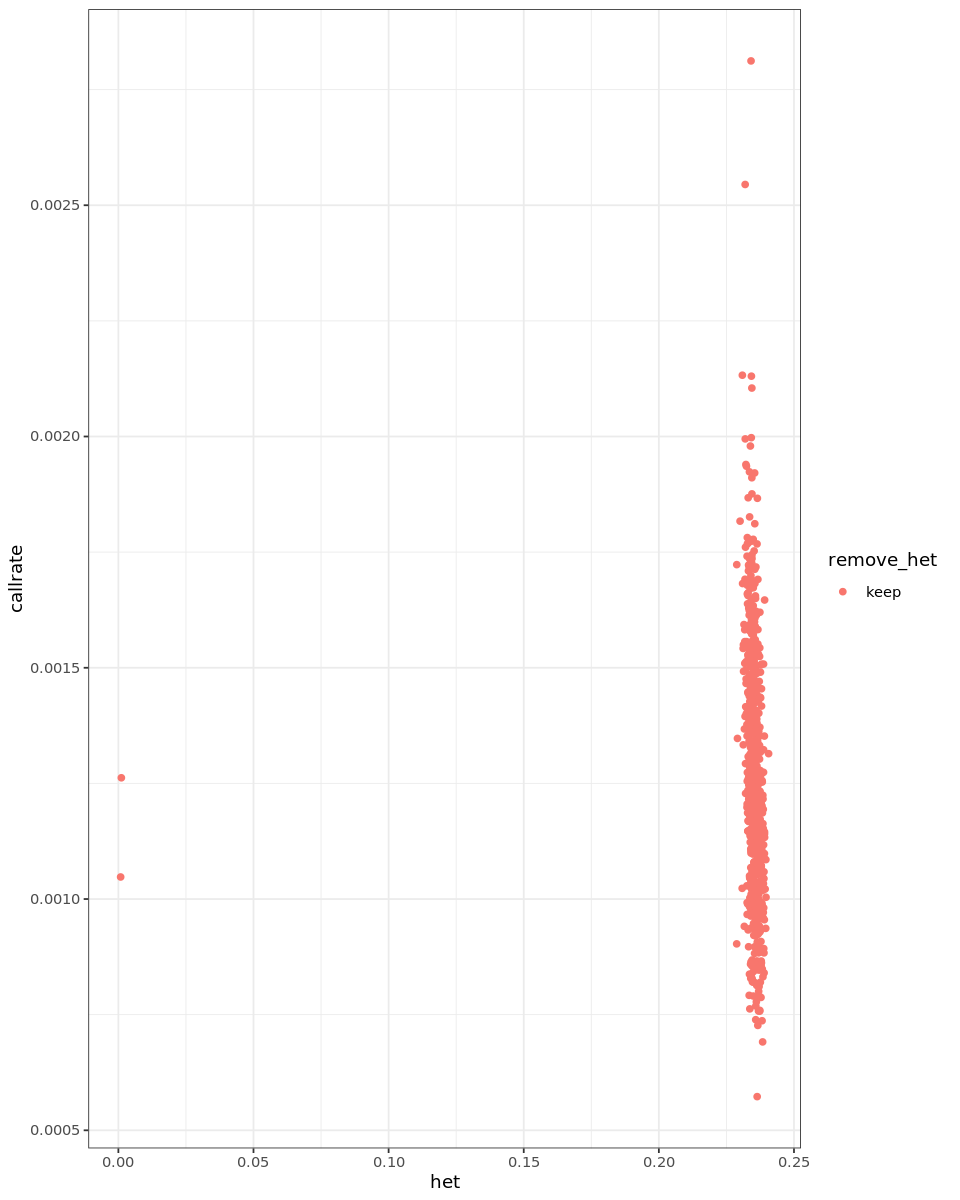

In [21]:
#Read in sample heterozygosity table
sample_het <- het_data
#Read in sample call rate table
sample_callrate <- smiss_data

#Calculate proportion of heterozygosity
sample_het <- sample_het %>%
  mutate(het = (OBS_CT - `O(HOM)`)/OBS_CT)

#Calculate mean and SD of heterozygosity
summary <- sample_het %>%
  summarise(mean_het = mean(het),
            sd_het = sd(het))

mean_het <- summary[1,1]
sd_het <- summary[1,2]

#Write list of samples who are > 2 SDs from mean of heterozygosity
sample_het <- sample_het %>%
  mutate(remove_het = ifelse(het > 2*sd_het + mean_het, "remove",
                             ifelse(het < mean_het - 2*sd_het, "remove", "keep")))

#Merge with callrate table
sample_stats <- sample_het %>%
  left_join(sample_callrate, by = c("#FID", "IID"))

sample_stats <- sample_stats %>%
  mutate(callrate = F_MISS)

#Plot scatterplot
options(repr.plot.width=8, repr.plot.height=10)
ggplot(data = sample_stats, mapping = aes(x = het, y = callrate, color = remove_het)) +
  geom_point() +
  theme_bw() 

#Write list of samples to remove - if heterozygosity outliers or if callrate is <98%
samples_to_remove <- sample_stats %>%
  filter(remove_het == "remove" | callrate > 0.015) %>%
  select("#FID", IID)

samples_to_remove

In [35]:
#Read in sample heterozygosity table
sample_het <- het_data
#Read in sample call rate table
sample_callrate <- smiss_data

#Calculate proportion of heterozygosity
sample_het <- sample_het %>%
  mutate(het = (OBS_CT - `O(HOM)`)/OBS_CT)

#Calculate mean and SD of heterozygosity
summary <- sample_het %>%
  summarise(mean_het = mean(het),
            sd_het = sd(het))

mean_het <- summary[1,1]
sd_het <- summary[1,2]


#Write list of samples who are > 2 SDs from mean of heterozygosity
sample_het <- sample_het %>%
  mutate(remove_het = ifelse((het > 3*sd_het + mean_het) | (het < mean_het - 3*sd_het),"remove", "keep"))

# sample_het <- sample_het %>%
#     mutate(remove_het = case_when(het > (2*sd_het + mean_het) ~ "remove",
#                                   het < (mean_het - 2*sd_het) ~ "remove",
#                                   TRUE ~ "keep"))

In [ ]:
#### There is a bug here, and I believe it could be an issue from Terra.

# The thing is that, by looking at the plo, clearly there are two outliers, but they are not tagged as outliers 
# when trying to find them with a vectorised code.

# For now, I will just manually save these two samples I am displaying below.

In [31]:
which(sample_het$het < 0.15)

[1] 19 20

In [41]:
sample_het[19:20,]
# Checking one of them is definitley an het outlier
0.0011013681 < (mean_het - 3*sd_het)

#FID,IID,O(HOM),E(HOM),OBS_CT,F,het,remove_het
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
PD-PDAL120HLU,PD-PDAL120HLU,2448184186,-1846840000,2450883511,0.0223913,0.0011013681,keep
PD-PDAL676UX0,PD-PDAL676UX0,3227897369,-1067110000,3230615904,0.0159636,0.0008414912,keep


mean_het
TRUE


In [43]:
#Write heterozygosity outliers.
write.table(sample_het[19:20,][1:2], "/home/jupyter/notebooks/working_dir/het_2SD_outliers_secondround.txt",
            row.names = FALSE, quote = FALSE, col.names = FALSE)